In [1]:
#Libs
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import datetime
import os
import time
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%load_ext tensorboard

In [2]:
#Reconhecimento GPU
dispositivo_fisico = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Disponíveis: ', len(dispositivo_fisico))
tf.config.experimental.set_memory_growth(dispositivo_fisico[0], True)

Num GPUs Disponíveis:  1


In [3]:
#Caminhos para as imagens
train_path = 'data/bm-vs-av-v2-augmented/train'
valid_path = 'data/bm-vs-av-v2-augmented/valid'
test_path = 'data/bm-vs-av-v2-augmented/test'

In [4]:
#Batches para geração de dados das imagens
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), 
                         classes=['acaro-vermelho', 'bicho-mineiro'], 
                         batch_size=10)
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), 
                         classes=['acaro-vermelho', 'bicho-mineiro'], 
                         batch_size=10)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), 
                         classes=['acaro-vermelho', 'bicho-mineiro'], 
                         batch_size=10, 
                         shuffle=False)

Found 2966 images belonging to 2 classes.
Found 102 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [5]:
#Gera batch de imagens e labels de um training set
imgs, labels = next(train_batches)

In [6]:
#plot imagens from the trained batch (tensorflow site)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(28,28))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow((img * 255).astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

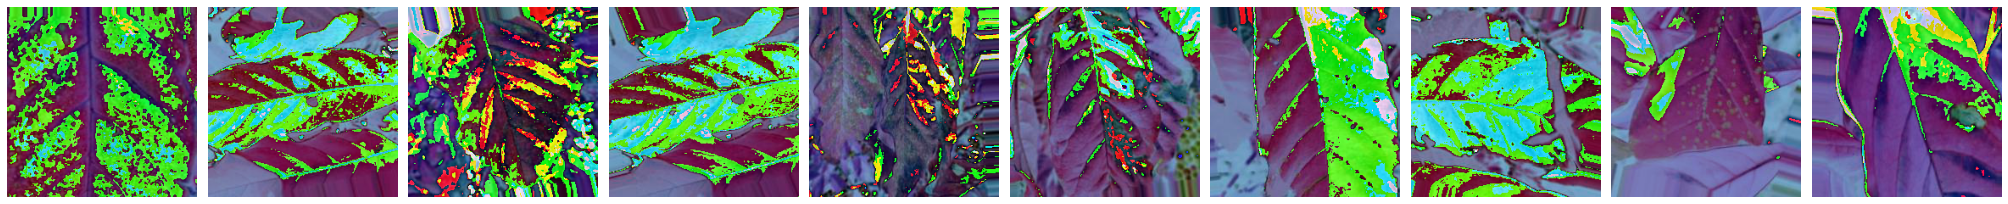

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [7]:
#VGG16 Pre process Input (tf.keras.applications.vgg16.preprocess_input)
plotImages(imgs)
print(labels)

# Custom CNN

In [8]:
#First approach of an CNN
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
#tensorboard
#logdir = os.path.join("logs", "custom-cnn-30epochs")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [12]:
#Treinamento
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=30,
          verbose=2
          #,callbacks=[tensorboard_callback]
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 297 steps, validate for 11 steps
Epoch 1/30
297/297 - 18s - loss: 9.7631 - accuracy: 0.7343 - val_loss: 1.9226 - val_accuracy: 0.7843
Epoch 2/30
297/297 - 16s - loss: 0.6533 - accuracy: 0.9107 - val_loss: 0.7360 - val_accuracy: 0.8824
Epoch 3/30
297/297 - 16s - loss: 0.1905 - accuracy: 0.9595 - val_loss: 0.5352 - val_accuracy: 0.9118
Epoch 4/30
297/297 - 16s - loss: 0.0919 - accuracy: 0.9815 - val_loss: 0.3029 - val_accuracy: 0.9020
Epoch 5/30
297/297 - 16s - loss: 0.0156 - accuracy: 0.9939 - val_loss: 0.7800 - val_accuracy: 0.8725
Epoch 6/30
297/297 - 16s - loss: 0.0045 - accuracy: 0.9980 - val_loss: 0.2870 - val_accuracy: 0.9216
Epoch 7/30
297/297 - 16s - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.5799 - val_accuracy: 0.8824
Epoch 8/30
297/297 - 16s - loss: 0.0017 - accuracy: 0.9990 - val_loss: 0.2380 - val_accuracy: 0.9020
Epoch 9/30
297/297 - 16s - loss: 9.9063e-05 - accuracy: 1.0000 - val_loss: 0.2912 - val_accuracy: 0

In [13]:
#%tensorboard --logdir logs

In [14]:
test_imgs, test_labels = next(test_batches)

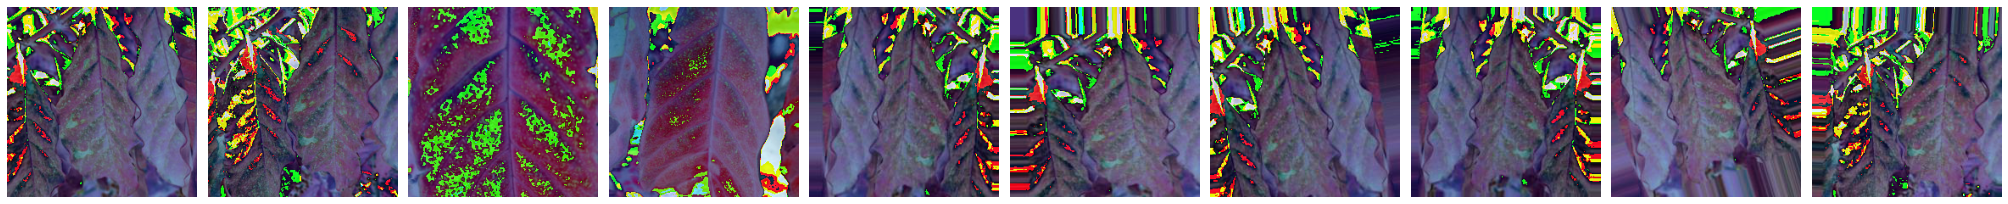

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
plotImages(test_imgs)
print(test_labels)

In [16]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [17]:
predictions = model.predict(x=test_batches, 
                            steps=len(test_batches), 
                            verbose=0)

In [18]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, 
                      y_pred=np.argmax(predictions, 
                                       axis=-1))

In [20]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz confusao normalizada")
    else:
        print('Matriz confusao sem estar normalizada')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
test_batches.class_indices

{'acaro-vermelho': 0, 'bicho-mineiro': 1}

Matriz confusao sem estar normalizada
[[74  6]
 [20 86]]


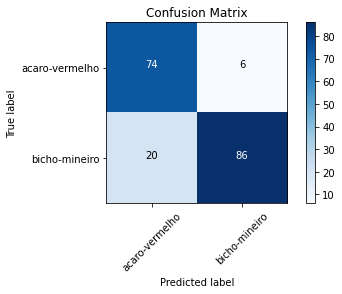

In [23]:
cm_plot_labels = ['acaro-vermelho','bicho-mineiro']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')